# system rozpoznawania komend głosowych

Projekt na przedmioty:
- eksploracja danych biomedycznych
- głosowa łączność z komputerem

Zadaniem projektu jest stworzenie systemu zdolnego do rozpoznawania zestawu komend głosowych, które mogłyby być potencjalnie wykorzystane do sterowania inteligentnym budynkiem.

Zbiorem wykorzystanym przy budowie klasyfikatora są nagrania stworzone przez studentów Informatyki i Elektroniki Medycznej. 56 zestawów nagrań po 13 komend zostało odpowiednio przetransformowane.

### biblioteki

In [2]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import csv
import os
import glob
import librosa
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import itertools
%matplotlib notebook
plt.rcParams['figure.figsize'] = [8, 8]
#plt.ioff()
import warnings
warnings.filterwarnings('ignore')

### import danych do jednej struktury

In [3]:
pliki = glob.glob("C:/Users/Alicja/Documents/GitHub/the_voice/data/*.wav")
labelki = glob.glob("C:/Users/Alicja/Documents/GitHub/the_voice/data/*.txt")
data_list = list()
command_list = list()

for x in range (0, len(pliki)):
    sample, data = wav.read(pliki[x], mmap=False)
    labels = list(csv.reader(open(labelki[x], 'r'), delimiter='\t'))
    
    for i in range (0,len(labels)):
        data_list.append(data[int(float(labels[i][0])*sample)-1 : int(float(labels[i][1])*sample)+1])
        command_list.append(labels[i][2])

### przetwarzanie danych

Na potrzeby liczonych atrybutów dane muszą zostać przekonwertowane, ponieważ część nagrań została zapisana z użyciem intów, a część floatów.

Atrybuty wyliczane w tym projekcie wykorzystują bibliotekę librosa i są to:
- krótkoczasowa transformacja Fouriera
- mfcc - Mel-frequency cepstrum
- chromagramy
- spektogramy mel-skalowane
- kontrast spektrogramów
- parametry dotyczące centroidów związanych z tonami

In [4]:
# konwersja typów
for i in range(0,len(data_list)):
    if (isinstance(data_list[i][0], np.ndarray)):
        X = np.array(data_list[i], dtype=float)
        data_list[i] = np.reshape(X, X.shape[0]*X.shape[1])

# wyliczenie        
features = np.empty((0,193))
for i in range(0,len(data_list)):
    X = np.array(data_list[i], dtype=float)
    sample_rate = 44100
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack((features,ext_features))

In [5]:
# utworzenie wektora klas (slow) w reprezentacji przyjaznej algorytmowi
slowa = np.zeros((728,1))
slowa[0] = 1
for i in range (1, len(slowa)):
    slowa[i] = (i+1)%13
    if slowa[i] == 0:
        slowa[i] = 13
        
real_data = np.concatenate((features, slowa), axis=1)

### model dla jednej osoby

Model taki nie powinien być traktowany na serio. Każda osoba nagrała tylko 4 zestawy komend, co dość mocno ogranicza możliwości treningu jak i testowania. Zdecydowano się na współczynnik podziału danych 3:1.

In [31]:
train = real_data[(520):(559)]
test = real_data[(559):(572)]

X_train = train[:, 0:193]
y_train = train[:,193:194]

X_test = test[:, 0:193]
y_test = test[:,193:194]

In [32]:
# czas na SVM
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf',  C=10.0, random_state=1) # TUNING
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)

print('SVM dokładność: %.2f' % accuracy_score(y_test, y_pred))
print('SVM wynik: %.2f' % svm.score(X_test_std, y_test))

SVM dokładność: 0.85
SVM wynik: 0.85


<IPython.core.display.Javascript object>


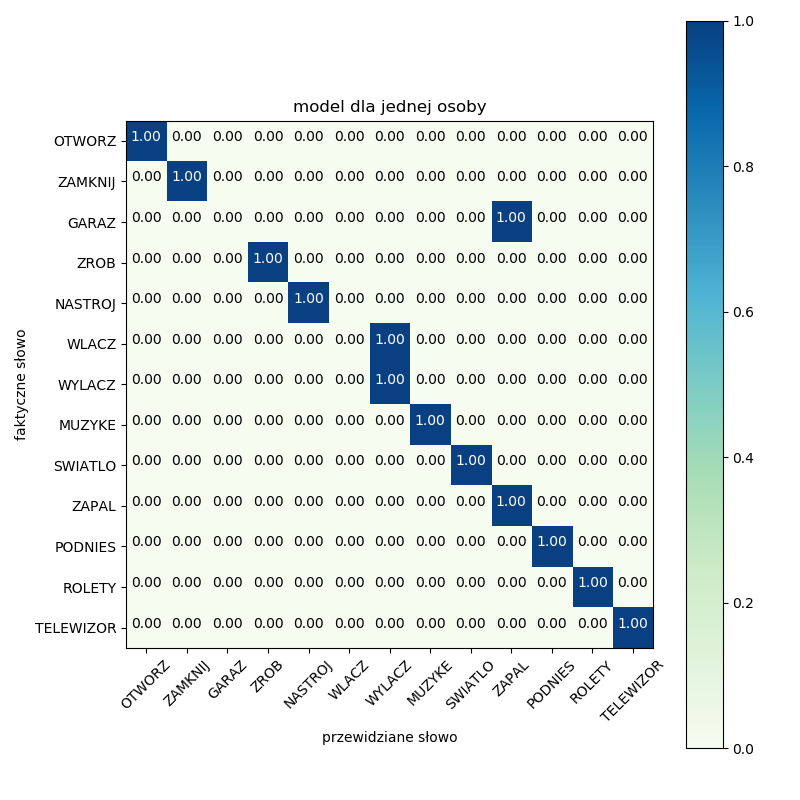

In [33]:
# tworzenie wykresu
mat = confusion_matrix(y_test, y_pred)
class_names = ['OTWORZ', 'ZAMKNIJ', 'GARAZ', 'ZROB', 'NASTROJ', 'WLACZ', 'WYLACZ', 'MUZYKE', 'SWIATLO', 'ZAPAL', 'PODNIES',
              'ROLETY', 'TELEWIZOR']


mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='GnBu')
plt.title('model dla jednej osoby')
plt.colorbar()
plt.ylabel('faktyczne słowo')
plt.xlabel('przewidziane słowo')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
fmt = '.2f'
thresh = mat.max() / 2.
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    plt.text(j, i, format(mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if mat[i, j] > thresh else "black")


plt.show()

### model dla wszystkich osób

Model Tworzony poniżej wykorzystuje dane stworzone przez wszystkich członków projektu - 14 różnych osób, kobiet i mężczyzn, wszystkich w sile wieku, czyli około 23. roku życia.

In [94]:
train = real_data[:663]
test = real_data[663:len(real_data)]

X_train = train[:, 0:193]
y_train = train[:,193:194]

X_test = test[:, 0:193]
y_test = test[:,193:194]

In [95]:
# czas na SVM
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf',  C=10.0, random_state=1) # TUNING
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)

print('SVM dokładność: %.2f' % accuracy_score(y_test, y_pred))
print('SVM wynik: %.2f' % svm.score(X_test_std, y_test))

SVM dokładność: 0.71
SVM wynik: 0.71


<IPython.core.display.Javascript object>


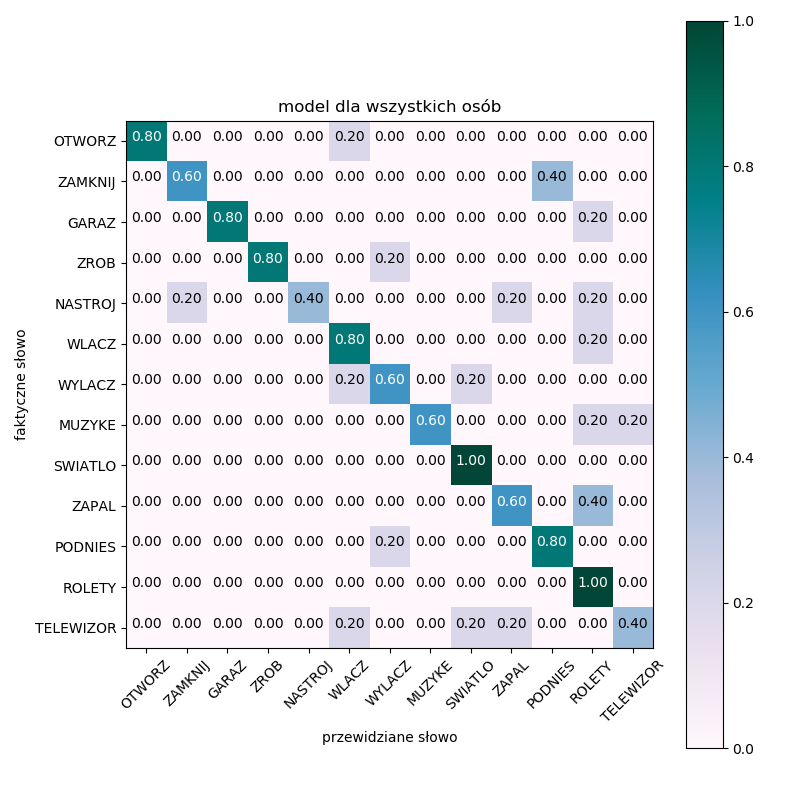

In [96]:
# tworzenie wykresu
mat = confusion_matrix(y_test, y_pred)
class_names = ['OTWORZ', 'ZAMKNIJ', 'GARAZ', 'ZROB', 'NASTROJ', 'WLACZ', 'WYLACZ', 'MUZYKE', 'SWIATLO', 'ZAPAL', 'PODNIES',
              'ROLETY', 'TELEWIZOR']


mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='PuBuGn')
plt.title('model dla wszystkich osób')
plt.colorbar()
plt.ylabel('faktyczne słowo')
plt.xlabel('przewidziane słowo')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
fmt = '.2f'
thresh = mat.max() / 2.
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    plt.text(j, i, format(mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if mat[i, j] > thresh else "black")


plt.show()

### modele zależne od płci osoby wypowiadającej komendę

Postanowiono dodatkowo stworzyć modele uzwględniające płeć osoby wypowiadającą komendę. Ma to na celu sprawdzenie jak bardzo klasyfikacja jest zależna od oczywistych różnic w głosach kobiet i mężczyzn.

#### model dla kobiet

In [158]:
# wyciągnięcie plików nagranych przez kobiety
indexes = []
for i in range (0,len(labelki)):
    if(labelki[i].find("_K_") != -1):
        indexes.append(i)

In [159]:
woman_rec = [x for x in range(0,13)]
for n in range(1, len(indexes)):
    woman_rec.extend([x for x in range((13*indexes[n]),(13*indexes[n]+13))])

In [123]:
train = real_data[woman_rec]
test = real_data[woman_rec]

train = train[26:len(real_data[woman_rec])]
test = test[:26]

X_train = train[:, 0:193]
y_train = train[:,193:194]

X_test = test[:, 0:193]
y_test = test[:,193:194]

In [124]:
# czas na SVM
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf',  C=10.0, random_state=1) # TUNING
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)

print('SVM dokładność: %.2f' % accuracy_score(y_test, y_pred))
print('SVM wynik: %.2f' % svm.score(X_test_std, y_test))

SVM dokładność: 0.62
SVM wynik: 0.62


<IPython.core.display.Javascript object>


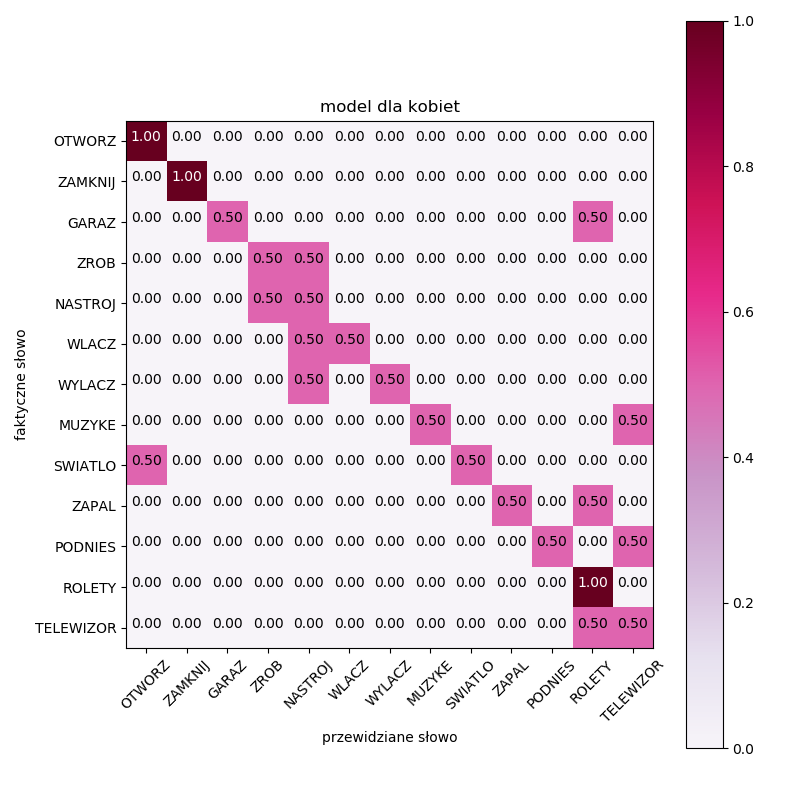

In [125]:
# tworzenie wykresu
mat = confusion_matrix(y_test, y_pred)
class_names = ['OTWORZ', 'ZAMKNIJ', 'GARAZ', 'ZROB', 'NASTROJ', 'WLACZ', 'WYLACZ', 'MUZYKE', 'SWIATLO', 'ZAPAL', 'PODNIES',
              'ROLETY', 'TELEWIZOR']


mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='PuRd')
plt.title('model dla kobiet')
plt.colorbar()
plt.ylabel('faktyczne słowo')
plt.xlabel('przewidziane słowo')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
fmt = '.2f'
thresh = mat.max() / 2.
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    plt.text(j, i, format(mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if mat[i, j] > thresh else "black")


plt.show()

#### model dla mężczyzn

In [162]:
# wyciągnięcie plików nagranych przez mężczyzn
indexes = []
for i in range (0,len(labelki)):
    if(labelki[i].find("_M_") != -1):
        indexes.append(i)

In [163]:
man_rec = []
for n in range(0, len(indexes)):
    man_rec.extend([x for x in range((13*indexes[n]),(13*indexes[n]+13))])

In [176]:
train = real_data[man_rec]
test = real_data[man_rec]

train = train[:299]
test = test[299:len(real_data[man_rec])]

X_train = train[:, 0:193]
y_train = train[:,193:194]

X_test = test[:, 0:193]
y_test = test[:,193:194]

In [177]:
# czas na SVM
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf',  C=10.0, random_state=1) # TUNING
svm.fit(X_train_std, y_train)

y_pred = svm.predict(X_test_std)

print('SVM dokładność: %.2f' % accuracy_score(y_test, y_pred))
print('SVM wynik: %.2f' % svm.score(X_test_std, y_test))

SVM dokładność: 0.74
SVM wynik: 0.74


<IPython.core.display.Javascript object>


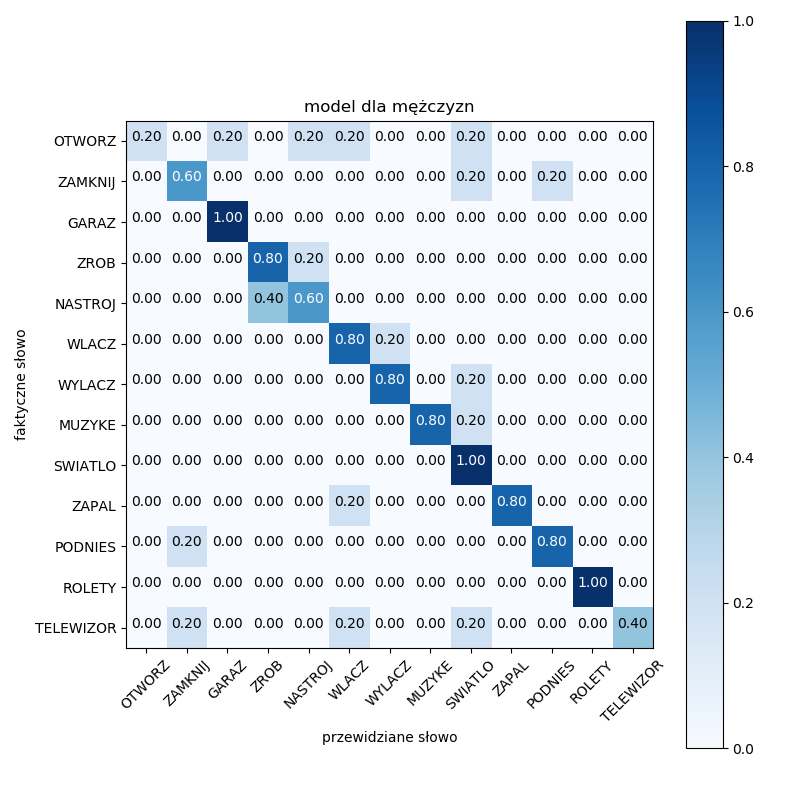

In [178]:
# tworzenie wykresu
mat = confusion_matrix(y_test, y_pred)
class_names = ['OTWORZ', 'ZAMKNIJ', 'GARAZ', 'ZROB', 'NASTROJ', 'WLACZ', 'WYLACZ', 'MUZYKE', 'SWIATLO', 'ZAPAL', 'PODNIES',
              'ROLETY', 'TELEWIZOR']


mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='Blues')
plt.title('model dla mężczyzn')
plt.colorbar()
plt.ylabel('faktyczne słowo')
plt.xlabel('przewidziane słowo')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
fmt = '.2f'
thresh = mat.max() / 2.
for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    plt.text(j, i, format(mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if mat[i, j] > thresh else "black")


plt.show()

### podsumowanie

Otrzymane modele uzyskały następujące skuteczności na zbiorach testowych:
- 85% dla jednej osoby
- 71% dla wszystkich osób
- 62% dla kobiet
- 74% dla mężczyzn

Wspomniane rezultaty można ulepszyć poprzez dodatkowe przetworzenie sygnałów wejściowych.